Download And Import requirement

In [ ]:
!pip install pyspark
!pip install xgboost
!pip install imblearn
!pip install -U pandas scikit-learn imbalanced-learn xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 130.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 8.7 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.4
    Uninstalling xgboost-2.1.4:
      Successfully uninstalled xgboost-2.1.4
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.0 which is incompatible.
cudf-cu12 25.2.1 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 which is incompatible.
dask-cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 which

In [ ]:
import os
import subprocess
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, desc, mean, count as spark_count, udf, rand, sum as spark_sum, lit
from pyspark.sql.types import DoubleType, StringType, IntegerType
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, Imputer
from pyspark.ml.classification import RandomForestClassifier
from xgboost.spark import SparkXGBClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors
from imblearn.over_sampling import SMOTE
import random
import time


In [ ]:
!java -version

openjdk version "11.0.27" 2025-04-15
OpenJDK Runtime Environment (build 11.0.27+6-post-Ubuntu-0ubuntu122.04)
OpenJDK 64-Bit Server VM (build 11.0.27+6-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)


Spark Declaration

In [ ]:
spark = SparkSession.builder \
    .getOrCreate()

In [ ]:
spark = SparkSession.builder \
    .appName("Stroke Prediction Full Code") \
    .config("spark.jars.packages", "ml.dmlc:xgboost4j-spark_2.12:1.7.0,ml.dmlc:xgboost4j_2.12:1.7.0") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("Stroke Prediction Optimized Training") \
    .config("spark.jars.packages", "ml.dmlc:xgboost4j-spark_2.12:1.7.0,ml.dmlc:xgboost4j_2.12:1.7.0") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "16g") \
    .config("spark.driver.maxResultSize", "12g") \
    .getOrCreate()

Data Preparation

In [ ]:
# file_path = '/content/drive/MyDrive/BDP/healthcare-dataset-stroke-data.csv'  # Path ke file dataset
# # df = pd.read_csv(file_path)
file_path = 'healthcare-dataset-stroke-data.csv'

In [ ]:
# Load dataset
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Menampilkan schema
df.printSchema()
df.show(20)

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: string (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|  

Data Preprocessing

In [ ]:
df = df.dropna(subset=['stroke'])

In [ ]:
# # Periksa Nilai Unik pada 'Stage'
# df_cleaned = df
# df_cleaned.groupBy("stroke").couprint("Jumlah N/A (null) pada kolom 'bmi' SEBELUM imputasi:")
df.select(spark_count(when(col("bmi").isNull() | (col("bmi") == 'N/A'), "bmi")).alias("N/A sebelum imputasi")).show()
df = df.withColumn("bmi", col("bmi").cast(DoubleType()))

imputer_bmi = Imputer(inputCols=["bmi"], outputCols=["bmi_imputed"], strategy="median")
df_cleaned = imputer_bmi.fit(df).transform(df)
df_cleaned = df_cleaned.drop("bmi")
df_cleaned = df_cleaned.withColumnRenamed("bmi_imputed", "bmi")

imputer_bmi = Imputer(inputCols=["bmi"], outputCols=["bmi_imputed"], strategy="median")
df_cleaned = imputer_bmi.fit(df).transform(df)
df_cleaned = df_cleaned.drop("bmi")
df_cleaned = df_cleaned.withColumnRenamed("bmi_imputed", "bmi")
print("N/A di bmi setelah imputasi:")
df_cleaned.select(spark_count(when(col("bmi").isNull(), "bmi")).alias("N/A")).show()

+--------------------+
|N/A sebelum imputasi|
+--------------------+
|                 201|
+--------------------+

N/A di bmi setelah imputasi:
+---+
|N/A|
+---+
|  0|
+---+



In [ ]:
# from xgboost.spark import SparkXGBClassifierprint("Jumlah Unknown pada kolom 'bmi' SEBELUM imputasi:")
df_cleaned.select(spark_count(when(col("smoking_status") == "Unknown", "smoking_status")).alias("Smoking unknown")).show()

smoking_counts = df_cleaned.filter(col("smoking_status") != "Unknown") \
                           .groupBy("smoking_status").count().collect()
total_known_smoking = sum([row["count"] for row in smoking_counts])

if total_known_smoking > 0:
    smoking_proportions = {row["smoking_status"]: row["count"] / total_known_smoking for row in smoking_counts}
    status_list = list(smoking_proportions.keys())
    probabilities = list(smoking_proportions.values())

    cumulative_probabilities = np.cumsum(probabilities).tolist()

    def assign_random_smoking_status():
        random_val = float(np.random.rand())
        for i, cum_prob in enumerate(cumulative_probabilities):
            if random_val < cum_prob:
                return status_list[i]
        return status_list[-1]

    assign_random_smoking_status_udf = udf(assign_random_smoking_status, StringType())

    df_cleaned = df_cleaned.withColumn("smoking_status_imputed",
                                     when(col("smoking_status") == "Unknown", assign_random_smoking_status_udf())
                                     .otherwise(col("smoking_status")))
    df_cleaned = df_cleaned.drop("smoking_status")
    df_cleaned = df_cleaned.withColumnRenamed("smoking_status_imputed", "smoking_status")
    print("Distribusi smoking_status setelah imputasi 'Unknown':")
    df_cleaned.groupBy("smoking_status").count().show()
else:
    print("Tidak ada data smoking_status yang diketahui untuk melakukan imputasi 'Unknown'.")




+---------------+
|Smoking unknown|
+---------------+
|           1544|
+---------------+

Distribusi smoking_status setelah imputasi 'Unknown':
+---------------+-----+
| smoking_status|count|
+---------------+-----+
|         smokes| 1110|
|   never smoked| 2723|
|formerly smoked| 1277|
+---------------+-----+



In [ ]:
gender_counts_df = df_cleaned.groupBy("gender").count()
dominant_gender_row = gender_counts_df.filter(col("gender") != "Other") \
                                      .orderBy(desc("count")) \
                                      .first()
most_frequent_gender = "Male"
if dominant_gender_row:
    most_frequent_gender = dominant_gender_row["gender"]
else:
    fallback_gender_row = gender_counts_df.orderBy(desc("count")).first()
    if fallback_gender_row and fallback_gender_row["gender"] != "Other":
        most_frequent_gender = fallback_gender_row["gender"]
    elif fallback_gender_row:
         print("Peringatan: Hanya gender 'Other' yang ditemukan atau kolom gender kosong setelah filter awal. Menggunakan default 'Male'.")

print(f"Mengganti gender 'Other' dengan: {most_frequent_gender}")
df_cleaned = df_cleaned.withColumn("gender",
                                   when(col("gender") == "Other", most_frequent_gender)
                                   .otherwise(col("gender")))
print("Distribusi gender setelah penggantian 'Other':")
df_cleaned.groupBy("gender").count().show()


Mengganti gender 'Other' dengan: Female
Distribusi gender setelah penggantian 'Other':
+------+-----+
|gender|count|
+------+-----+
|Female| 2995|
|  Male| 2115|
+------+-----+



In [ ]:
numeric_cols_to_convert = ['age', 'avg_glucose_level', 'bmi']
for c in numeric_cols_to_convert:
    df_cleaned = df_cleaned.withColumn(c, col(c).cast(DoubleType()))

binary_cols_to_convert = ['hypertension', 'heart_disease', 'stroke']
for c in binary_cols_to_convert:
    df_cleaned = df_cleaned.withColumn(c, col(c).cast(IntegerType()))

print("Skema data setelah pembersihan awal dan imputasi:")
df_cleaned.printSchema()
print("Data sampel setelah pembersihan:")
df_cleaned.show(5, truncate=False)

Skema data setelah pembersihan awal dan imputasi:
root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- stroke: integer (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = true)

Data sampel setelah pembersihan:
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+------+----+---------------+
|id   |gender|age |hypertension|heart_disease|ever_married|work_type    |Residence_type|avg_glucose_level|stroke|bmi |smoking_status |
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+------+----+---------------+
|9046 |

In [ ]:
cols_to_remove_list = ['id', 'ever_married', 'work_type', 'Residence_type']
current_df_cleaned_columns = df_cleaned.columns
actual_cols_to_remove = [col_name for col_name in cols_to_remove_list if col_name in current_df_cleaned_columns]

print(f"Daftar kolom yang akan coba dihilangkan (actual_cols_to_remove): {actual_cols_to_remove}")

if actual_cols_to_remove:
    df_cleaned_after_drop = df_cleaned.drop(*actual_cols_to_remove)
    df_cleaned = df_cleaned_after_drop

df_cleaned.printSchema()
print(df_cleaned.columns)
df_cleaned.show(5, truncate=False)

Daftar kolom yang akan coba dihilangkan (actual_cols_to_remove): ['id', 'ever_married', 'work_type', 'Residence_type']
root
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- stroke: integer (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = true)

['gender', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'stroke', 'bmi', 'smoking_status']
+------+----+------------+-------------+-----------------+------+----+---------------+
|gender|age |hypertension|heart_disease|avg_glucose_level|stroke|bmi |smoking_status |
+------+----+------------+-------------+-----------------+------+----+---------------+
|Male  |67.0|0           |1            |228.69           |1     |36.6|formerly smoked|
|Female|61.0|0           |0            |202.21           |1     |28.0|never smoked   |


In [ ]:
categorical_cols = [field.name for field in df_cleaned.schema.fields if isinstance(field.dataType, StringType)]
numerical_cols = [field.name for field in df_cleaned.schema.fields if isinstance(field.dataType, (DoubleType, IntegerType)) and field.name != 'stroke']

if 'stroke' in categorical_cols:
    print("Peringatan: Kolom 'stroke' terdeteksi di categorical_cols. Ini akan dihapus.")
    categorical_cols = [c for c in categorical_cols if c != 'stroke']
    print(f"Kolom kategorikal setelah penyesuaian: {categorical_cols}")

if categorical_cols:
    indexers = [StringIndexer(inputCol=column, outputCol=column+"_indexed", handleInvalid="keep") for column in categorical_cols]
    pipeline_indexer = Pipeline(stages=indexers)
    df_indexed = pipeline_indexer.fit(df_cleaned).transform(df_cleaned)
    indexed_categorical_cols = [c+"_indexed" for c in categorical_cols]
else:
    print("Tidak ada kolom kategorikal (string) yang ditemukan untuk di-StringIndex.")
    df_indexed = df_cleaned
    indexed_categorical_cols = []


feature_columns_for_assembler = numerical_cols + indexed_categorical_cols

missing_cols_in_df_indexed = [fc for fc in feature_columns_for_assembler if fc not in df_indexed.columns]

assembler = VectorAssembler(inputCols=feature_columns_for_assembler, outputCol="unscaled_features", handleInvalid="skip")
df_assembled = assembler.transform(df_indexed)

# StandardScaler
scaler = StandardScaler(inputCol="unscaled_features", outputCol="features", withStd=True, withMean=True)
scaler_model = scaler.fit(df_assembled)
df_scaled = scaler_model.transform(df_assembled)

# Final DataFrame for modeling
df_final = df_scaled.select("features", "stroke") # Pastikan 'stroke' ada di df_scaled
print("\nData final siap untuk modeling (df_final):")
df_final.show(5, truncate=False)


Data final siap untuk modeling (df_final):
+--------------------------------------------------------------------------------------------------------------------------------------------+------+
|features                                                                                                                                    |stroke|
+--------------------------------------------------------------------------------------------------------------------------------------------+------+
|[1.0513313991807545,-0.3285697091631481,4.184622475198168,2.706110616938918,1.005444433901707,1.1898733258610663,0.3803098924354114]        |1     |
|[0.7859931540178339,-0.3285697091631481,-0.23892341811226608,2.1213509400949206,-0.11144213124043303,-0.8402611299486329,-0.852801497377375]|1     |
|[1.6262309303670828,-0.3285697091631481,4.184622475198168,-0.005027809274735759,0.47297525749673325,1.1898733258610663,-0.852801497377375]  |1     |
|[0.2553166636919924,-0.3285697091631481,-0.238923418112

Visualisasi Awal Data

<ipython-input-17-cfb516e5c217>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='gender', data=gender_pd_overall, palette='pastel')


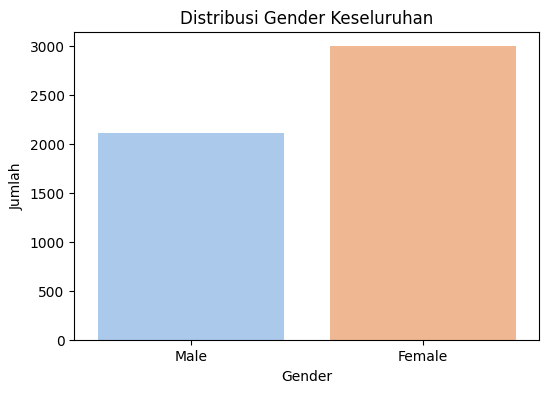

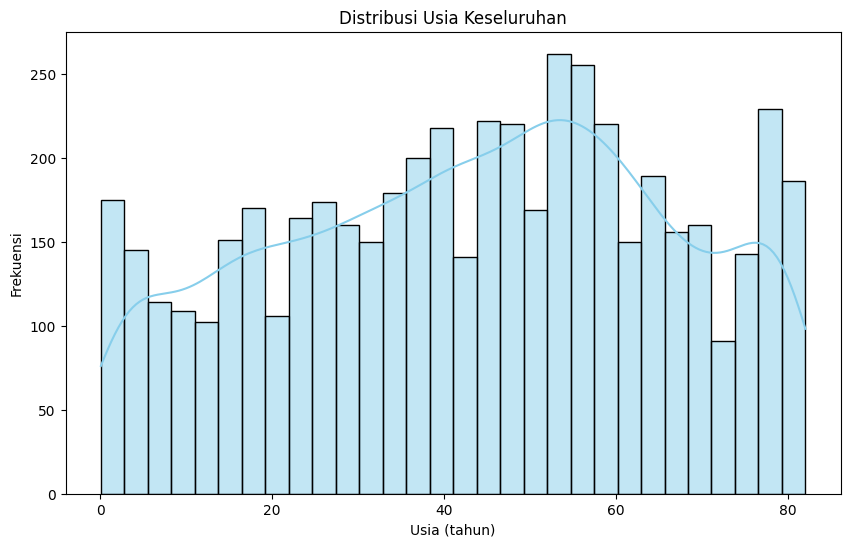

<ipython-input-17-cfb516e5c217>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='hypertension', data=hypertension_pd_overall, palette='coolwarm')


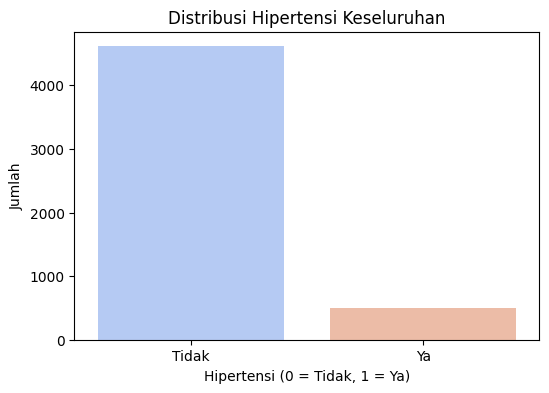

<ipython-input-17-cfb516e5c217>:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='heart_disease', data=heart_disease_pd_overall, palette='viridis')


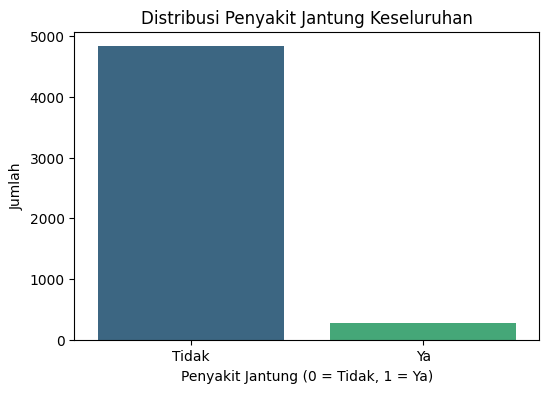

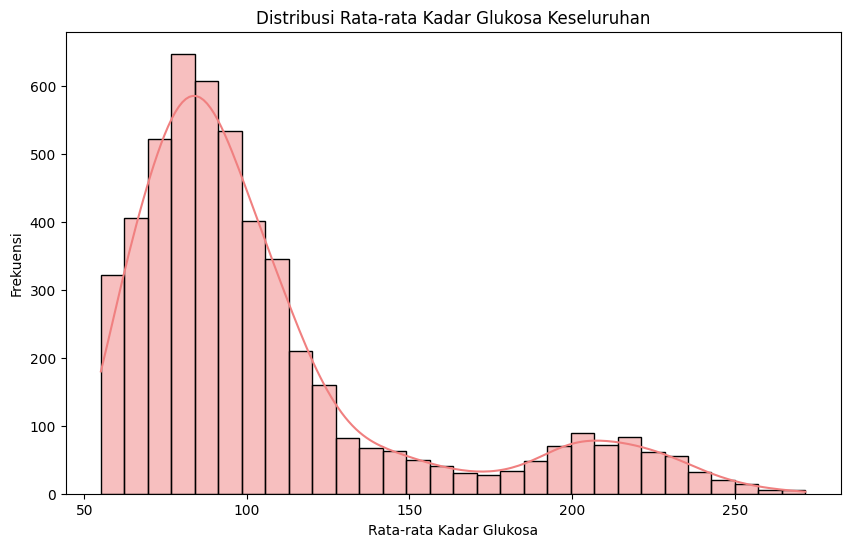

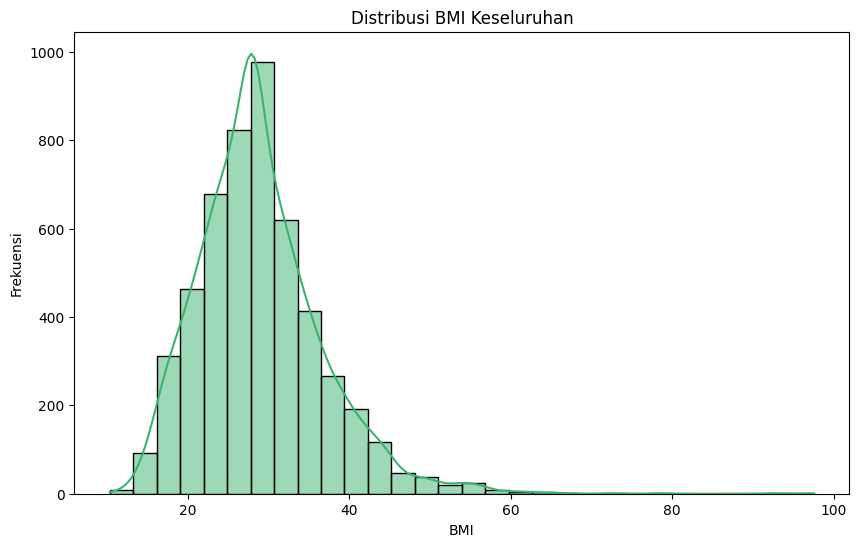

In [ ]:
# 1. Distribusi Gender (keseluruhan)
if "gender" in df_cleaned.columns:
    gender_pd_overall = df_cleaned.select("gender").toPandas()
    if not gender_pd_overall.empty:
        plt.figure(figsize=(6, 4))
        sns.countplot(x='gender', data=gender_pd_overall, palette='pastel')
        plt.title('Distribusi Gender Keseluruhan')
        plt.xlabel('Gender')
        plt.ylabel('Jumlah')
        plt.show()
else:
    print("Kolom 'gender' tidak ditemukan untuk plot distribusi.")

# 2. Distribusi Usia (keseluruhan)
if "age" in df_cleaned.columns:
    age_pd_overall = df_cleaned.select("age").toPandas()
    if not age_pd_overall.empty:
        plt.figure(figsize=(10, 6))
        sns.histplot(age_pd_overall['age'], bins=30, kde=True, color='skyblue')
        plt.title('Distribusi Usia Keseluruhan')
        plt.xlabel('Usia (tahun)')
        plt.ylabel('Frekuensi')
        plt.show()
else:
    print("Kolom 'age' tidak ditemukan untuk plot distribusi.")

# 3. Distribusi Hipertensi (keseluruhan)
if "hypertension" in df_cleaned.columns:
    hypertension_pd_overall = df_cleaned.select("hypertension").toPandas()
    if not hypertension_pd_overall.empty:
        plt.figure(figsize=(6, 4))
        sns.countplot(x='hypertension', data=hypertension_pd_overall, palette='coolwarm')
        plt.title('Distribusi Hipertensi Keseluruhan')
        plt.xlabel('Hipertensi (0 = Tidak, 1 = Ya)')
        plt.ylabel('Jumlah')
        plt.xticks(ticks=[0, 1], labels=['Tidak', 'Ya'])
        plt.show()
else:
    print("Kolom 'hypertension' tidak ditemukan untuk plot distribusi.")

# 4. Distribusi Penyakit Jantung (keseluruhan) - Menggunakan countplot
if "heart_disease" in df_cleaned.columns:
    heart_disease_pd_overall = df_cleaned.select("heart_disease").toPandas()
    if not heart_disease_pd_overall.empty:
        plt.figure(figsize=(6, 4))
        sns.countplot(x='heart_disease', data=heart_disease_pd_overall, palette='viridis')
        plt.title('Distribusi Penyakit Jantung Keseluruhan')
        plt.xlabel('Penyakit Jantung (0 = Tidak, 1 = Ya)')
        plt.ylabel('Jumlah')
        plt.xticks(ticks=[0, 1], labels=['Tidak', 'Ya'])
        plt.show()
else:
    print("Kolom 'heart_disease' tidak ditemukan untuk plot distribusi.")

# 5. Distribusi Rata-rata Kadar Glukosa (keseluruhan)
if "avg_glucose_level" in df_cleaned.columns:
    glucose_pd_overall = df_cleaned.select("avg_glucose_level").toPandas()
    if not glucose_pd_overall.empty:
        plt.figure(figsize=(10, 6))
        sns.histplot(glucose_pd_overall['avg_glucose_level'], bins=30, kde=True, color='lightcoral')
        plt.title('Distribusi Rata-rata Kadar Glukosa Keseluruhan')
        plt.xlabel('Rata-rata Kadar Glukosa')
        plt.ylabel('Frekuensi')
        plt.show()
else:
    print("Kolom 'avg_glucose_level' tidak ditemukan untuk plot distribusi.")

# 6. Distribusi BMI (keseluruhan)
if "bmi" in df_cleaned.columns:
    bmi_pd_overall = df_cleaned.select("bmi").toPandas()
    if not bmi_pd_overall.empty:
        plt.figure(figsize=(10, 6))
        sns.histplot(bmi_pd_overall['bmi'], bins=30, kde=True, color='mediumseagreen')
        plt.title('Distribusi BMI Keseluruhan')
        plt.xlabel('BMI')
        plt.ylabel('Frekuensi')
        plt.show()
else:
    print("Kolom 'bmi' tidak ditemukan untuk plot distribusi.")

Jumlah pasien stroke untuk visualisasi: 249


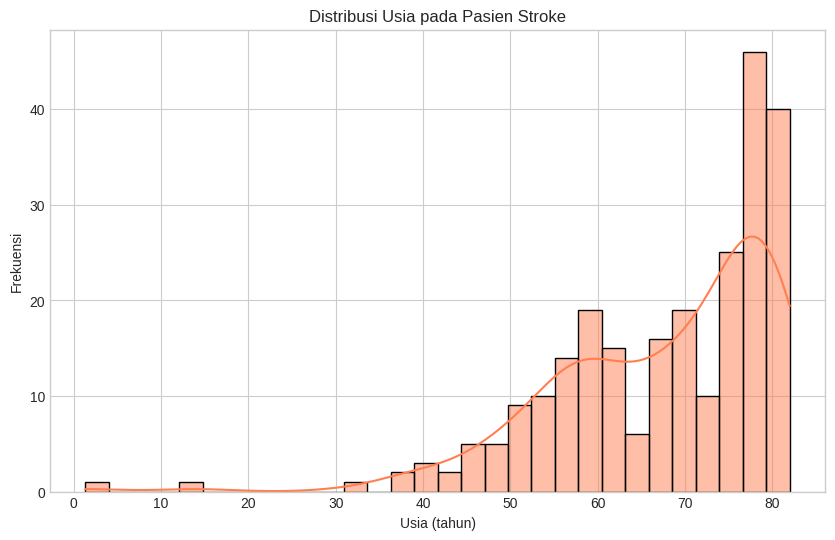

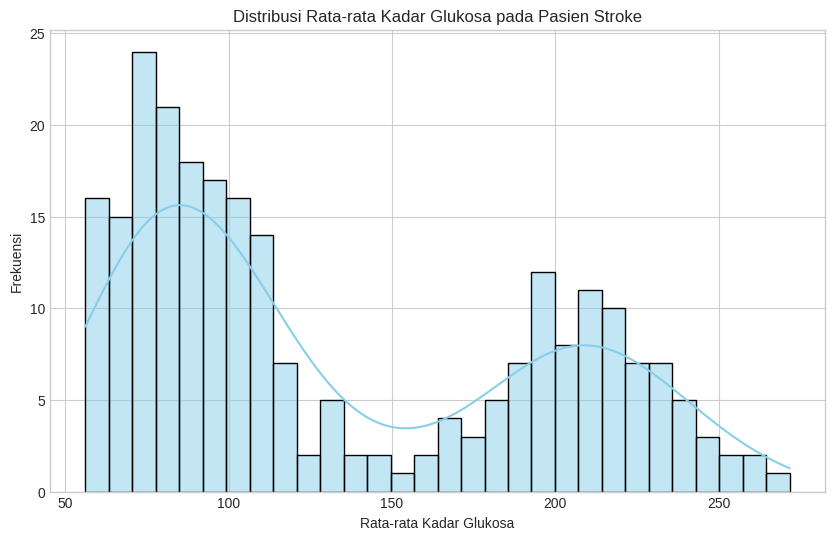

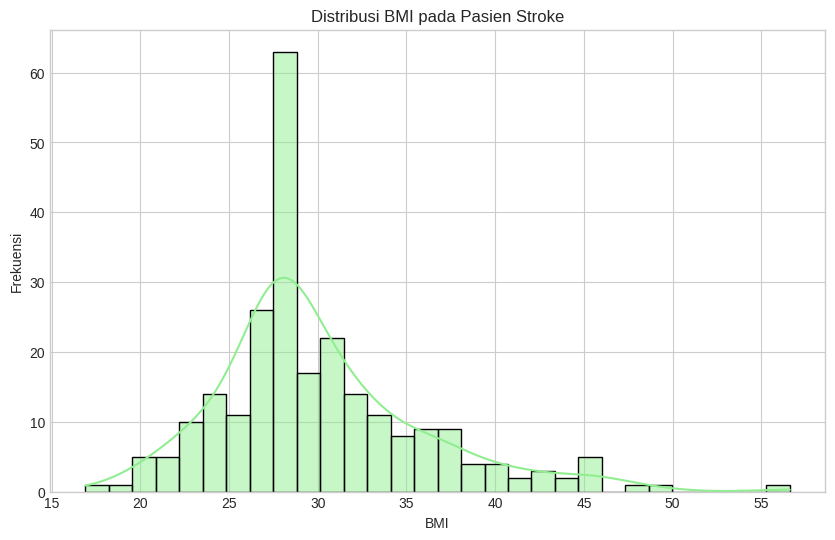

<ipython-input-18-418b560d9f03>:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="hypertension", data=hypertension_pd_stroke, palette="pastel")


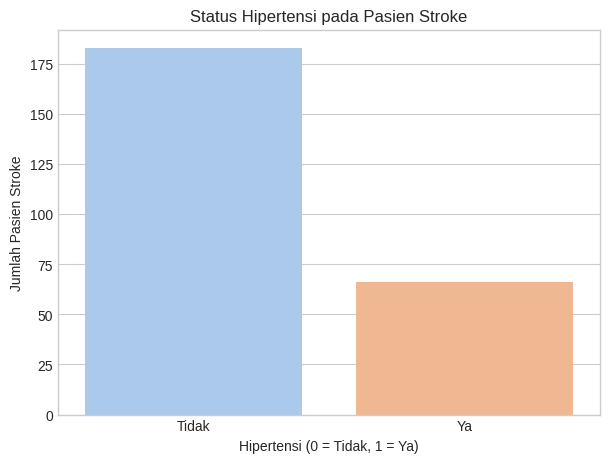

<ipython-input-18-418b560d9f03>:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="heart_disease", data=heart_disease_pd_stroke, palette="Set2")


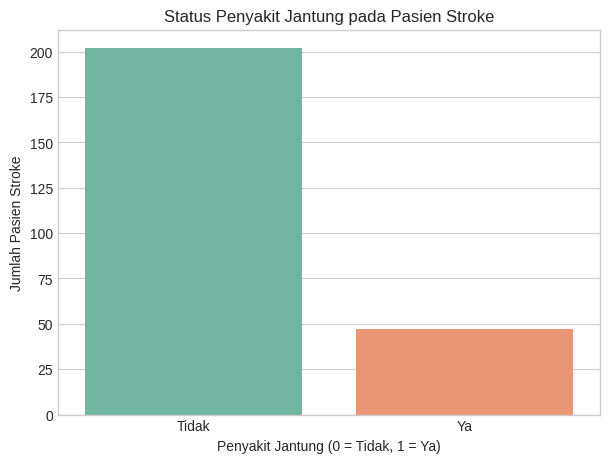


--- Distribusi Fitur Kategorikal Lainnya di Kalangan Pasien Stroke ---


<ipython-input-18-418b560d9f03>:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=cat_col, data=df_categorical_remaining_among_stroke_pd, ax=axes[i], palette='coolwarm')
<ipython-input-18-418b560d9f03>:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=cat_col, data=df_categorical_remaining_among_stroke_pd, ax=axes[i], palette='coolwarm')


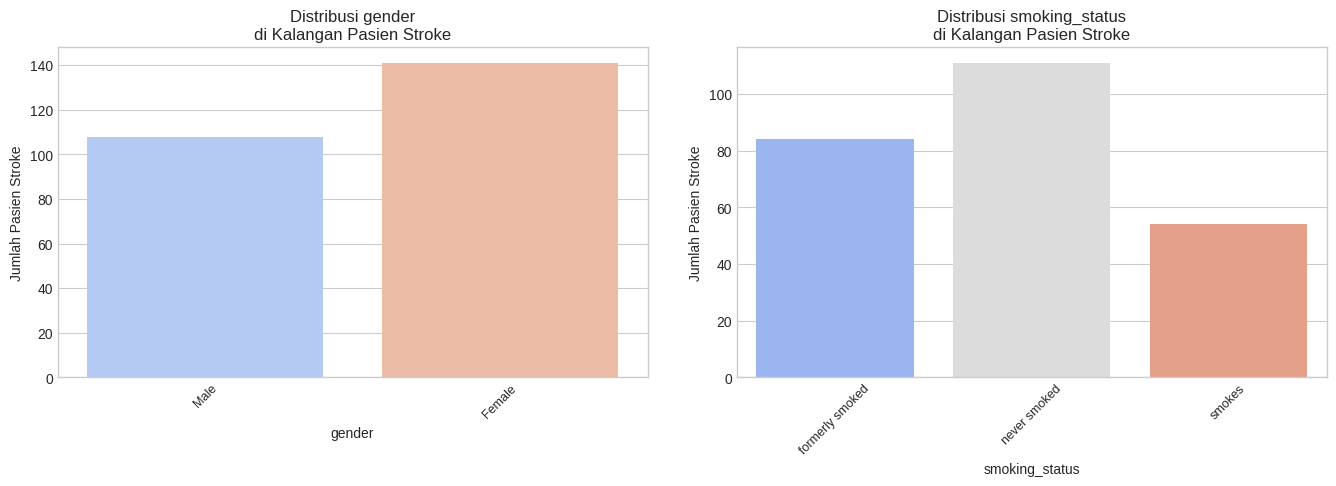

In [ ]:
class_labels = ["Not Stroke (0)", "Stroke (1)"]
df_stroke_patients = df_cleaned.filter(col("stroke") == 1)
print(f"Jumlah pasien stroke untuk visualisasi: {df_stroke_patients.count()}")

if not df_stroke_patients.rdd.isEmpty():
    age_pd_stroke = df_stroke_patients.select("age").toPandas() if "age" in df_stroke_patients.columns else pd.DataFrame()
    glucose_pd_stroke = df_stroke_patients.select("avg_glucose_level").toPandas() if "avg_glucose_level" in df_stroke_patients.columns else pd.DataFrame()
    bmi_pd_stroke = df_stroke_patients.select("bmi").toPandas() if "bmi" in df_stroke_patients.columns else pd.DataFrame()
    hypertension_pd_stroke = df_stroke_patients.select("hypertension").toPandas() if "hypertension" in df_stroke_patients.columns else pd.DataFrame()
    heart_disease_pd_stroke = df_stroke_patients.select("heart_disease").toPandas() if "heart_disease" in df_stroke_patients.columns else pd.DataFrame()

    plt.style.use('seaborn-v0_8-whitegrid')

    # age
    if not age_pd_stroke.empty:
        plt.figure(figsize=(10, 6))
        sns.histplot(age_pd_stroke["age"], kde=True, bins=30, color="coral")
        plt.title("Distribusi Usia pada Pasien Stroke")
        plt.xlabel("Usia (tahun)")
        plt.ylabel("Frekuensi")
        plt.show()

    # glucose
    if not glucose_pd_stroke.empty:
        plt.figure(figsize=(10, 6))
        sns.histplot(glucose_pd_stroke["avg_glucose_level"], kde=True, bins=30, color="skyblue")
        plt.title("Distribusi Rata-rata Kadar Glukosa pada Pasien Stroke")
        plt.xlabel("Rata-rata Kadar Glukosa")
        plt.ylabel("Frekuensi")
        plt.show()

    # bmi
    if not bmi_pd_stroke.empty:
        plt.figure(figsize=(10, 6))
        sns.histplot(bmi_pd_stroke["bmi"], kde=True, bins=30, color="lightgreen")
        plt.title("Distribusi BMI pada Pasien Stroke")
        plt.xlabel("BMI")
        plt.ylabel("Frekuensi")
        plt.show()

    # hypertension
    if not hypertension_pd_stroke.empty:
        plt.figure(figsize=(7, 5))
        sns.countplot(x="hypertension", data=hypertension_pd_stroke, palette="pastel")
        plt.title("Status Hipertensi pada Pasien Stroke")
        plt.xlabel("Hipertensi (0 = Tidak, 1 = Ya)")
        plt.ylabel("Jumlah Pasien Stroke")
        plt.xticks([0, 1], ['Tidak', 'Ya'])
        plt.show()

    # heart disease
    if not heart_disease_pd_stroke.empty:
        plt.figure(figsize=(7, 5))
        sns.countplot(x="heart_disease", data=heart_disease_pd_stroke, palette="Set2")
        plt.title("Status Penyakit Jantung pada Pasien Stroke")
        plt.xlabel("Penyakit Jantung (0 = Tidak, 1 = Ya)")
        plt.ylabel("Jumlah Pasien Stroke")
        plt.xticks([0, 1], ['Tidak', 'Ya'])
        plt.show()

print("\n--- Distribusi Fitur Kategorikal Lainnya di Kalangan Pasien Stroke ---")
categorical_features_remaining_for_plot = [
    col_name for col_name in ['gender', 'smoking_status']
    if col_name in df_cleaned.columns
]

if df_stroke_patients.count() > 0 and categorical_features_remaining_for_plot:
    df_categorical_remaining_among_stroke_pd = df_stroke_patients.select(categorical_features_remaining_for_plot).toPandas()

    if not df_categorical_remaining_among_stroke_pd.empty:
        num_cat_features = len(categorical_features_remaining_for_plot)
        ncols_subplot = 2
        nrows_subplot = (num_cat_features + ncols_subplot - 1) // ncols_subplot

        fig, axes = plt.subplots(nrows=nrows_subplot, ncols=ncols_subplot, figsize=(14, nrows_subplot * 5.5))
        if num_cat_features == 1:
            axes = [axes]
        else:
            axes = axes.flatten()

        for i, cat_col in enumerate(categorical_features_remaining_for_plot):
            if i < len(axes):
                sns.countplot(x=cat_col, data=df_categorical_remaining_among_stroke_pd, ax=axes[i], palette='coolwarm')
                axes[i].set_title(f'Distribusi {cat_col}\ndi Kalangan Pasien Stroke')
                axes[i].set_xlabel(cat_col)
                axes[i].set_ylabel('Jumlah Pasien Stroke')
                axes[i].tick_params(axis='x', rotation=45, labelsize=9)
                axes[i].title.set_fontsize(12)

        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout(pad=3.0)
        plt.show()


--- Pie Chart: Proporsi Relatif Kejadian Kondisi Kunci di Kalangan Pasien Stroke ---
Pie Chart: Menggunakan threshold glukosa tinggi (persentil ke-75 pasien stroke): 195.23 mg/dL


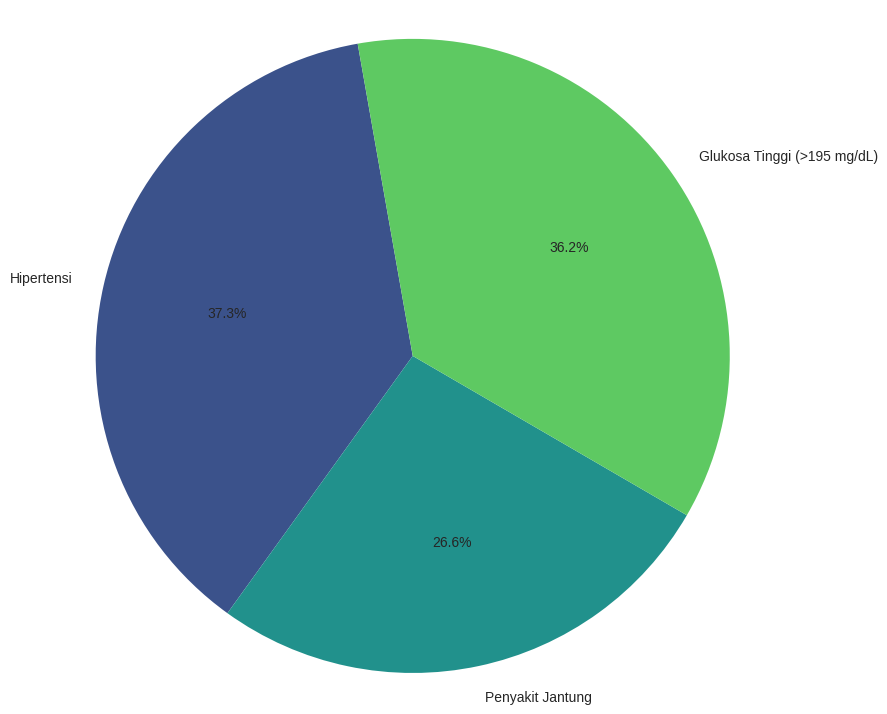

In [ ]:
print("\n--- Pie Chart: Proporsi Relatif Kejadian Kondisi Kunci di Kalangan Pasien Stroke ---")

if df_stroke_patients.count() > 0:
    high_glucose_threshold_for_pie = None
    glucose_threshold_label_part = ""

    if "avg_glucose_level" in df_stroke_patients.columns:
        try:
            quantiles = df_stroke_patients.approxQuantile("avg_glucose_level", [0.75], 0.01)
            if quantiles and quantiles[0] is not None:
                high_glucose_threshold_for_pie = quantiles[0]
                glucose_threshold_label_part = f" (>{high_glucose_threshold_for_pie:.0f} mg/dL)"
                print(f"Pie Chart: Menggunakan threshold glukosa tinggi (persentil ke-75 pasien stroke): {high_glucose_threshold_for_pie:.2f} mg/dL")
            else:
                high_glucose_threshold_for_pie = 160.0
                glucose_threshold_label_part = f" (>{high_glucose_threshold_for_pie:.0f} mg/dL)"
                print(f"Pie Chart: Gagal menghitung persentil glukosa, menggunakan nilai default: {high_glucose_threshold_for_pie} mg/dL")
        except Exception as e_quantile:
            high_glucose_threshold_for_pie = 160.0
            glucose_threshold_label_part = f" (>{high_glucose_threshold_for_pie:.0f} mg/dL)"
            print(f"Pie Chart: Error saat menghitung persentil glukosa ({e_quantile}). Menggunakan nilai default: {high_glucose_threshold_for_pie} mg/dL")
    else:
        print("Pie Chart: Kolom 'avg_glucose_level' tidak ditemukan. Slice 'Glukosa Tinggi' tidak akan disertakan atau bernilai 0.")

    df_stroke_patients_temp_pie = df_stroke_patients
    if high_glucose_threshold_for_pie is not None and "avg_glucose_level" in df_stroke_patients_temp_pie.columns:
        df_stroke_patients_temp_pie = df_stroke_patients_temp_pie.withColumn(
            "has_high_glucose_flag",
            when(col("avg_glucose_level") > high_glucose_threshold_for_pie, 1).otherwise(0)
        )
    else:
        df_stroke_patients_temp_pie = df_stroke_patients_temp_pie.withColumn("has_high_glucose_flag", lit(0))

    count_hypertension = 0
    if "hypertension" in df_stroke_patients_temp_pie.columns:
        count_hypertension = df_stroke_patients_temp_pie.filter(col("hypertension") == 1).count()
    else:
        print("Pie Chart: Kolom 'hypertension' tidak ditemukan. Kejadian hipertensi akan dihitung sebagai 0.")

    count_heart_disease = 0
    if "heart_disease" in df_stroke_patients_temp_pie.columns:
        count_heart_disease = df_stroke_patients_temp_pie.filter(col("heart_disease") == 1).count()
    else:
        print("Pie Chart: Kolom 'heart_disease' tidak ditemukan. Kejadian penyakit jantung akan dihitung sebagai 0.")

    count_high_glucose = df_stroke_patients_temp_pie.filter(col("has_high_glucose_flag") == 1).count()

    pie_chart_labels = []
    pie_chart_values = []

    if count_hypertension > 0:
        pie_chart_labels.append("Hipertensi")
        pie_chart_values.append(count_hypertension)

    if count_heart_disease > 0:
        pie_chart_labels.append("Penyakit Jantung")
        pie_chart_values.append(count_heart_disease)

    if high_glucose_threshold_for_pie is not None and count_high_glucose > 0 :
        pie_chart_labels.append(f"Glukosa Tinggi{glucose_threshold_label_part}")
        pie_chart_values.append(count_high_glucose)
    elif high_glucose_threshold_for_pie is None:
         print("Pie Chart: Slice 'Glukosa Tinggi' tidak disertakan karena threshold tidak dapat ditentukan.")


    if pie_chart_values:
        total_occurrences = sum(pie_chart_values)
        if total_occurrences > 0 :
            plt.figure(figsize=(9, 9))
            plt.pie(
                pie_chart_values,
                labels=pie_chart_labels,
                autopct=lambda p: '{:.1f}%'.format(p) if p > 0 else '',
                startangle=100,
                colors=sns.color_palette("viridis", len(pie_chart_labels))
            )
            plt.axis('equal')  # Memastikan pie chart berbentuk lingkaran.
            plt.show()

Balancing Data

In [ ]:
train_data, test_data = df_final.randomSplit([0.8, 0.2], seed=1234)
print(f"Jumlah data training: {train_data.count()}")
print(f"Jumlah data testing: {test_data.count()}")

Jumlah data training: 4127
Jumlah data testing: 983


<ipython-input-21-69a87454e979>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='stroke', data=train_df_pd_for_plot, palette="pastel")


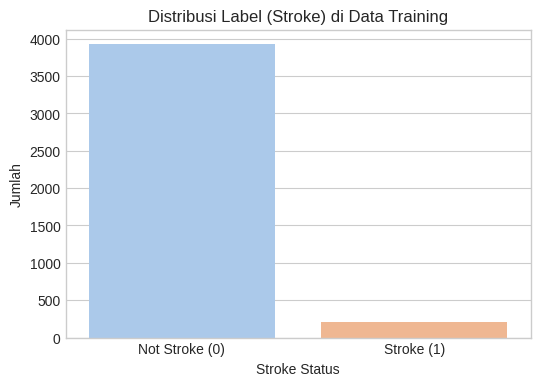

In [ ]:
train_df_pd_for_plot = train_data.select('stroke').toPandas()
plt.figure(figsize=(6, 4))
sns.countplot(x='stroke', data=train_df_pd_for_plot, palette="pastel")
plt.title('Distribusi Label (Stroke) di Data Training')
plt.xlabel('Stroke Status')
plt.ylabel('Jumlah')
plt.xticks(ticks=[0, 1], labels=class_labels)
plt.show()

In [ ]:
# SMOTE untuk Balancing Data
try:
    train_data_pd = train_data.select("features", "stroke").toPandas()
    X_train_list = [list(row.toArray()) for row in train_data_pd['features']]
    X_train_np = np.array(X_train_list)
    y_train_np = train_data_pd['stroke'].values

    print(f"Distribusi kelas sebelum SMOTE (NumPy):\n{np.unique(y_train_np, return_counts=True)[1]}")

except Exception as e:
    X_train_np, y_train_np = None, None


if X_train_np is not None and y_train_np is not None:
    smote = SMOTE(random_state=42, k_neighbors=5)

    unique_labels, counts = np.unique(y_train_np, return_counts=True)
    minority_class_label = unique_labels[np.argmin(counts)]
    minority_class_count = np.min(counts)

    if minority_class_count <= smote.k_neighbors:
        new_k = max(1, minority_class_count - 1)
        smote.k_neighbors = new_k

    if minority_class_count > 1 :
        X_train_resampled_np, y_train_resampled_np = smote.fit_resample(X_train_np, y_train_np)

        print(f"Distribusi kelas setelah SMOTE (NumPy):\n{np.unique(y_train_resampled_np, return_counts=True)[1]}")

        resampled_data_for_spark = []
        for i in range(len(X_train_resampled_np)):
            feature_vector = Vectors.dense(X_train_resampled_np[i])
            label = int(y_train_resampled_np[i])
            resampled_data_for_spark.append(Row(features=feature_vector, stroke=label))

        train_data_balanced = spark.createDataFrame(resampled_data_for_spark, schema=df_final.schema)

        print("Distribusi kelas pada train_data_balanced (Spark DataFrame):")
        train_data_balanced.groupBy("stroke").count().show()
    else:
        train_data_balanced = train_data
else:
    train_data_balanced = train_data


Distribusi kelas sebelum SMOTE (NumPy):
[3925  202]
Distribusi kelas setelah SMOTE (NumPy):
[3925 3925]
Distribusi kelas pada train_data_balanced (Spark DataFrame):
+------+-----+
|stroke|count|
+------+-----+
|     1| 3925|
|     0| 3925|
+------+-----+



Training Model

In [ ]:
# Declaration
rf = RandomForestClassifier(labelCol="stroke", featuresCol="features", seed=1234)
xg = SparkXGBClassifier(label_col="stroke", features_col="features", seed=1234)

evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="accuracy")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="f1")

In [ ]:
# Parameter Tuning
param_grid_rf_optimized = ParamGridBuilder() \
    .addGrid(rf.numTrees, [100, 150, 200]) \
    .addGrid(rf.maxDepth, [5, 8, 12]) \
    .addGrid(rf.minInstancesPerNode, [10, 20]) \
    .addGrid(rf.featureSubsetStrategy, ["auto", "sqrt"]) \
    .addGrid(rf.subsamplingRate, [0.8]) \
    .addGrid(rf.impurity, ["gini", "entropy"]) \
    .build()

param_grid_xg_optimized = ParamGridBuilder() \
    .addGrid(xg.max_depth, [4, 5, 7]) \
    .addGrid(xg.n_estimators, [150, 250]) \
    .addGrid(xg.learning_rate, [0.05, 0.1]) \
    .addGrid(xg.subsample, [0.8]) \
    .addGrid(xg.colsample_bytree, [0.8]) \
    .addGrid(xg.gamma, [0.1, 0.2]) \
    .addGrid(xg.reg_alpha, [0.01, 0.1]) \
    .addGrid(xg.reg_lambda, [1, 10]) \
    .build()

# Random Parameter
param_grid_rf_sampled = random.sample(param_grid_rf_optimized, min(20, len(param_grid_rf_optimized)))
param_grid_xg_sampled = random.sample(param_grid_xg_optimized, min(30, len(param_grid_xg_optimized)))

#Cross Validation
cv_rf_optimized = CrossValidator(
    estimator=rf,
    estimatorParamMaps=param_grid_rf_sampled,
    evaluator=evaluator_f1, # Use the evaluator defined before restarting Spark
    numFolds=5,
    parallelism=6,
    seed=42
)

cv_xg_optimized = CrossValidator(
    estimator=xg,
    estimatorParamMaps=param_grid_xg_sampled,
    evaluator=evaluator_f1, # Use the evaluator defined before restarting Spark
    numFolds=5,
    parallelism=6,
    seed=42
)

In [ ]:
# Incase Spark Ga Cukup
if 'spark' in globals() and spark:
    print("Stopping existing Spark session...")
    spark.stop()

# Recreate Spark session with larger memory allocation
print("Creating new Spark session with increased memory...")
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("Stroke Prediction Optimized Training") \
    .config("spark.jars.packages", "ml.dmlc:xgboost4j-spark_2.12:1.7.0,ml.dmlc:xgboost4j_2.12:1.7.0") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "16g") \
    .config("spark.driver.maxResultSize", "12g") \
    .getOrCreate()
print("New Spark session created.")
print("Recreating df_cleaned and df_final DataFrames with the new Spark session...")

file_path = 'healthcare-dataset-stroke-data.csv'

# Load dataset
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Data Preprocessing
df = df.dropna(subset=['stroke'])


Stopping existing Spark session...
Creating new Spark session with increased memory...
New Spark session created.
Recreating df_cleaned and df_final DataFrames with the new Spark session...


In [ ]:
# Impute BMI
df = df.withColumn("bmi", col("bmi").cast(DoubleType()))
imputer_bmi = Imputer(inputCols=["bmi"], outputCols=["bmi_imputed"], strategy="median")
if "bmi" in df.columns:
    df_cleaned = imputer_bmi.fit(df).transform(df)
    df_cleaned = df_cleaned.drop("bmi")
    df_cleaned = df_cleaned.withColumnRenamed("bmi_imputed", "bmi")
else:
    print("Warning: 'bmi' column not found for imputation.")
    df_cleaned = df # Proceed without BMI imputation if column is missing

# Impute smoking_status "Unknown"
if "smoking_status" in df_cleaned.columns:
    smoking_counts = df_cleaned.filter(col("smoking_status") != "Unknown") \
                               .groupBy("smoking_status").count().collect()
    total_known_smoking = sum([row["count"] for row in smoking_counts])

    if total_known_smoking > 0:
        smoking_proportions = {row["smoking_status"]: row["count"] / total_known_smoking for row in smoking_counts}
        status_list = list(smoking_proportions.keys())
        probabilities = list(smoking_proportions.values())
        cumulative_probabilities = np.cumsum(probabilities).tolist()

        # Define the UDF again if it was in a cell before the spark.stop()
        @udf(StringType())
        def assign_random_smoking_status():
            random_val = float(np.random.rand())
            for i, cum_prob in enumerate(cumulative_probabilities):
                if random_val < cum_prob:
                    return status_list[i]
            return status_list[-1]

        df_cleaned = df_cleaned.withColumn("smoking_status_imputed",
                                         when(col("smoking_status") == "Unknown", assign_random_smoking_status())
                                         .otherwise(col("smoking_status")))
        df_cleaned = df_cleaned.drop("smoking_status")
        df_cleaned = df_cleaned.withColumnRenamed("smoking_status_imputed", "smoking_status")
    else:
        print("Tidak ada data smoking_status yang diketahui untuk melakukan imputasi 'Unknown' setelah Spark restart.")
else:
    print("Warning: 'smoking_status' column not found for imputation.")

# Handle 'Other' gender (assuming this logic was correct before)
if "gender" in df_cleaned.columns:
    gender_counts_df = df_cleaned.groupBy("gender").count()
    dominant_gender_row = gender_counts_df.filter(col("gender") != "Other") \
                                          .orderBy(desc("count")) \
                                          .first()
    most_frequent_gender = "Male" # Default fallback
    if dominant_gender_row:
        most_frequent_gender = dominant_gender_row["gender"]
    else:
        # If no non-"Other" genders found, find the overall most frequent (could be "Other" if that's all there is)
        fallback_gender_row = gender_counts_df.orderBy(desc("count")).first()
        if fallback_gender_row:
             most_frequent_gender = fallback_gender_row["gender"]
             if most_frequent_gender == "Other":
                  print("Peringatan: Hanya gender 'Other' yang ditemukan atau kolom gender kosong. Menggunakan default 'Male'.")
                  most_frequent_gender = "Male" # Force "Male" if the only dominant is "Other"


    print(f"Replacing 'Other' gender with: {most_frequent_gender}")
    df_cleaned = df_cleaned.withColumn("gender",
                                    when(col("gender") == "Other", most_frequent_gender)
                                    .otherwise(col("gender")))
else:
    print("Warning: 'gender' column not found for imputation.")

numeric_cols_to_convert = ['age', 'avg_glucose_level', 'bmi']
for c in numeric_cols_to_convert:
    if c in df_cleaned.columns:
        df_cleaned = df_cleaned.withColumn(c, col(c).cast(DoubleType()))
    else:
        print(f"Warning: Column '{c}' not found for type casting.")


binary_cols_to_convert = ['hypertension', 'heart_disease', 'stroke']
for c in binary_cols_to_convert:
     if c in df_cleaned.columns:
        df_cleaned = df_cleaned.withColumn(c, col(c).cast(IntegerType()))
     else:
        print(f"Warning: Column '{c}' not found for type casting.")

cols_to_remove_list = ['id', 'ever_married', 'work_type', 'Residence_type']
current_df_cleaned_columns = df_cleaned.columns
actual_cols_to_remove = [col_name for col_name in cols_to_remove_list if col_name in current_df_cleaned_columns]

if actual_cols_to_remove:
    df_cleaned = df_cleaned.drop(*actual_cols_to_remove)
    print(f"Dropped columns: {actual_cols_to_remove}")
else:
    print("No columns from cols_to_remove_list were found in the DataFrame.")


Replacing 'Other' gender with: Female
Dropped columns: ['id', 'ever_married', 'work_type', 'Residence_type']


In [ ]:
# Feature Engineering
categorical_cols = [field.name for field in df_cleaned.schema.fields if isinstance(field.dataType, StringType) and field.name != 'stroke']
numerical_cols = [field.name for field in df_cleaned.schema.fields if isinstance(field.dataType, (DoubleType, IntegerType)) and field.name != 'stroke']

df_indexed = df_cleaned
indexed_categorical_cols = []
if categorical_cols:
    indexers = [StringIndexer(inputCol=column, outputCol=column+"_indexed", handleInvalid="keep") for column in categorical_cols]
    pipeline_indexer = Pipeline(stages=indexers)
    df_indexed = pipeline_indexer.fit(df_cleaned).transform(df_cleaned)
    indexed_categorical_cols = [c+"_indexed" for c in categorical_cols]
    print(f"Indexed categorical columns: {indexed_categorical_cols}")
else:
    print("No categorical (string) columns found to be StringIndexed after Spark restart.")


feature_columns_for_assembler = numerical_cols + indexed_categorical_cols
feature_columns_for_assembler = [c for c in feature_columns_for_assembler if c in df_indexed.columns]
if not feature_columns_for_assembler:
     raise ValueError("No feature columns found after reprocessing. Check data and preprocessing steps.")
print(f"Feature columns for assembler: {feature_columns_for_assembler}")

assembler = VectorAssembler(inputCols=feature_columns_for_assembler, outputCol="unscaled_features", handleInvalid="skip")
df_assembled = assembler.transform(df_indexed)

Indexed categorical columns: ['gender_indexed', 'smoking_status_indexed']
Feature columns for assembler: ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'gender_indexed', 'smoking_status_indexed']


In [ ]:
# StandardScaler
scaler = StandardScaler(inputCol="unscaled_features", outputCol="features", withStd=True, withMean=True)
scaler_model = scaler.fit(df_assembled)
df_scaled = scaler_model.transform(df_assembled)

if "stroke" not in df_scaled.columns:
     raise ValueError("'stroke' column missing from DataFrame after scaling. Cannot proceed.")
df_final = df_scaled.select("features", "stroke")
print("df_final successfully recreated with the new Spark session.")
print("\nData final ready for modeling (df_final):")
df_final.show(5, truncate=False)

print("Re-splitting data with the new Spark session...")
train_data, test_data = df_final.randomSplit([0.8, 0.2], seed=1234)
print(f"Number of training data (re-split): {train_data.count()}")
print(f"Number of testing data (re-split): {test_data.count()}")

df_final successfully recreated with the new Spark session.

Data final ready for modeling (df_final):
+---------------------------------------------------------------------------------------------------------------------------------------------+------+
|features                                                                                                                                     |stroke|
+---------------------------------------------------------------------------------------------------------------------------------------------+------+
|[1.0513313991807545,-0.3285697091631481,4.184622475198168,2.706110616938918,1.005444433901707,1.1898733258610663,0.38979966442588326]        |1     |
|[0.7859931540178339,-0.3285697091631481,-0.23892341811226608,2.1213509400949206,-0.11144213124043303,-0.8402611299486329,-0.8435602645005904]|1     |
|[1.6262309303670828,-0.3285697091631481,4.184622475198168,-0.005027809274735759,0.47297525749673325,1.1898733258610663,-0.8435602645005904]  

In [ ]:
print("Applying SMOTE on the re-split training data...")
try:
    train_count_before_smote = train_data.count()
    print(f"Training data count before SMOTE: {train_count_before_smote}")

    train_data_pd = train_data.select("features", "stroke").toPandas()
    X_train_list = [list(row.toArray()) for row in train_data_pd['features']]
    X_train_np = np.array(X_train_list)
    y_train_np = train_data_pd['stroke'].values

    print(f"Class distribution before SMOTE (NumPy):\n{np.unique(y_train_np, return_counts=True)[1]}")

    # Apply SMOTE
    # Use the correct k_neighbors based on minority class count after splitting
    unique_labels, counts = np.unique(y_train_np, return_counts=True)
    # Ensure minority class exists and count is sufficient for SMOTE
    if len(unique_labels) < 2 or np.min(counts) <= 1:
        print("Minority class count is too small (<= 1) for SMOTE or only one class exists. Skipping SMOTE.")
        train_data_balanced = train_data # Use the original training data if SMOTE cannot be applied
    else:
        minority_class_count = np.min(counts)
        smote_k_neighbors = min(5, max(1, minority_class_count - 1)) # Adjust k_neighbors dynamically

        smote = SMOTE(random_state=42, k_neighbors=smote_k_neighbors)
        print(f"Applying SMOTE with k_neighbors={smote_k_neighbors}.")

        X_train_resampled_np, y_train_resampled_np = smote.fit_resample(X_train_np, y_train_np)

        print(f"Class distribution after SMOTE (NumPy):\n{np.unique(y_train_resampled_np, return_counts=True)[1]}")

        # Convert back to Spark DataFrame using the *new* spark session
        resampled_data_for_spark = []
        for i in range(len(X_train_resampled_np)):
            feature_vector = Vectors.dense(X_train_resampled_np[i])
            label = int(y_train_resampled_np[i])
            resampled_data_for_spark.append(Row(features=feature_vector, stroke=label))

        # Use the schema from df_final which is compatible with the feature vector structure
        train_data_balanced = spark.createDataFrame(resampled_data_for_spark, schema=df_final.schema)

        print("Class distribution on train_data_balanced (Spark DataFrame):")
        train_data_balanced.groupBy("stroke").count().show()


except Exception as e:
    print(f"Error during SMOTE or converting data: {e}")
    # Fallback to using the original training data from the new session
    train_data_balanced = train_data
    print("Proceeding with original (unbalanced) training data from the new session.")

Applying SMOTE on the re-split training data...
Training data count before SMOTE: 4127
Class distribution before SMOTE (NumPy):
[3925  202]
Applying SMOTE with k_neighbors=5.
Class distribution after SMOTE (NumPy):
[3925 3925]
Class distribution on train_data_balanced (Spark DataFrame):
+------+-----+
|stroke|count|
+------+-----+
|     1| 3925|
|     0| 3925|
+------+-----+



In [ ]:
rf = RandomForestClassifier(labelCol="stroke", featuresCol="features", seed=1234)
xg = SparkXGBClassifier(label_col="stroke", features_col="features", seed=1234)

evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="accuracy")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="f1")
auc_evaluator = BinaryClassificationEvaluator(labelCol="stroke", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
precision_evaluator = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="weightedRecall")

cv_rf_optimized = CrossValidator(
    estimator=rf,
    estimatorParamMaps=param_grid_rf_sampled,
    evaluator=evaluator_f1,
    numFolds=5,
    parallelism=6,
    seed=42
)

cv_xg_optimized = CrossValidator(
    estimator=xg,
    estimatorParamMaps=param_grid_xg_sampled,
    evaluator=evaluator_f1,
    numFolds=5,
    parallelism=6,
    seed=42
)

In [ ]:
print("Starting Enhanced Training...")
start_time = time.time()

print("Training Random Forest".format(len(param_grid_rf_sampled)))
rf_start = time.time()
rf_model = cv_rf_optimized.fit(train_data_balanced)
rf_time = time.time() - rf_start
print(f"RF Training completed in {rf_time/60:.1f} minutes")

print("Training XGBoost ({} combinations, 5-fold CV)...".format(len(param_grid_xg_sampled)))
xg_start = time.time()
xg_model = cv_xg_optimized.fit(train_data_balanced)
xg_time = time.time() - xg_start
print(f"XGBoost Training completed in {xg_time/60:.1f} minutes")

total_time = time.time() - start_time
print(f"Total training time: {total_time/60:.1f} minutes")

Starting Enhanced Training...
Training Random Forest
RF Training completed in 0.8 minutes
Training XGBoost (30 combinations, 5-fold CV)...


INFO:XGBoost-PySpark:Running xgboost-3.0.2 on 1 workers with
	booster params: {'device': 'cpu', 'objective': 'binary:logistic', 'seed': 1234, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-3.0.2 on 1 workers with
	booster params: {'device': 'cpu', 'objective': 'binary:logistic', 'seed': 1234, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-3.0.2 on 1 workers with
	booster params: {'device': 'cpu', 'objective': 'binary:logistic', 'seed': 1234, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-3.0.2 on 1 workers with
	booster params: {'device': 'cpu', 'objective': 'binary:logistic', 'seed': 1234, 'nthread': 1}
	train_cal

XGBoost Training completed in 2.6 minutes
Total training time: 3.4 minutes


In [ ]:
from pyspark.sql.functions import udf, when, col
from pyspark.sql.types import DoubleType

# Asumsikan 'rf_predictions' adalah DataFrame hasil prediksi Anda pada test_data
# Pastikan Anda mendapatkan kolom 'probability'
best_rf_model = rf_model.bestModel
rf_predictions = best_rf_model.transform(test_data)

# Fungsi untuk mengekstrak probabilitas kelas positif (stroke)
get_prob_positive = udf(lambda v: float(v[1]), DoubleType())
preds_with_prob = rf_predictions.withColumn("prob_positive", get_prob_positive(col("probability")))

print("Mencari Threshold Terbaik untuk Random Forest...")
best_f1 = 0
best_threshold = 0.5

# Iterasi melalui beberapa nilai threshold
for threshold in np.arange(0.1, 0.6, 0.05):
    # Buat prediksi baru berdasarkan threshold saat ini
    preds_with_new_prediction = preds_with_prob.withColumn(
        "new_prediction",
        when(col("prob_positive") >= threshold, 1.0).otherwise(0.0)
    )

    # Evaluasi F1-score dengan prediksi baru
    evaluator_f1_temp = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="new_prediction", metricName="f1")
    f1 = evaluator_f1_temp.evaluate(preds_with_new_prediction)

    print(f"Threshold: {threshold:.2f}, F1-Score: {f1:.4f}")

    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print("-" * 30)
print(f"🎉 Threshold Optimal Ditemukan: {best_threshold:.2f} dengan F1-Score: {best_f1:.4f}")

Mencari Threshold Terbaik untuk Random Forest...
Threshold: 0.10, F1-Score: 0.4256
Threshold: 0.15, F1-Score: 0.6100
Threshold: 0.20, F1-Score: 0.7116
Threshold: 0.25, F1-Score: 0.7386
Threshold: 0.30, F1-Score: 0.7604
Threshold: 0.35, F1-Score: 0.7703
Threshold: 0.40, F1-Score: 0.7725
Threshold: 0.45, F1-Score: 0.7785
Threshold: 0.50, F1-Score: 0.7903
Threshold: 0.55, F1-Score: 0.8089
------------------------------
🎉 Threshold Optimal Ditemukan: 0.55 dengan F1-Score: 0.8089


In [ ]:
# Prediction
initial_rf_predictions = best_rf_model.transform(test_data)
OPTIMAL_RF_THRESHOLD = 0.55

get_prob_positive = udf(lambda v: float(v[1]), DoubleType())


rf_predictions = initial_rf_predictions \
    .withColumn("prob_positive", get_prob_positive(col("probability"))) \
    .withColumn("prediction", # Timpa kolom prediksi lama dengan yang baru
        when(col("prob_positive") >= OPTIMAL_RF_THRESHOLD, 1.0).otherwise(0.0)
    )
xg_predictions = xg_model.transform(test_data)

In [ ]:
# Evaluation
rf_accuracy = evaluator_accuracy.evaluate(rf_predictions) if "prediction" in rf_predictions.columns and "stroke" in rf_predictions.columns else float('nan')
rf_f1 = evaluator_f1.evaluate(rf_predictions) if "prediction" in rf_predictions.columns and "stroke" in rf_predictions.columns else float('nan')
rf_precision = precision_evaluator.evaluate(rf_predictions) if "prediction" in rf_predictions.columns and "stroke" in rf_predictions.columns else float('nan')
rf_recall = recall_evaluator.evaluate(rf_predictions) if "prediction" in rf_predictions.columns and "stroke" in rf_predictions.columns else float('nan')
rf_auc = auc_evaluator.evaluate(rf_predictions) if "rawPrediction" in rf_predictions.columns and "stroke" in rf_predictions.columns else float('nan')


if np.isnan(rf_accuracy): print("Warning: RF evaluation skipped due to missing required columns.")
if np.isnan(rf_precision): print("Warning: 'prediction' or 'stroke' column missing in RF predictions for precision/recall.")
if np.isnan(rf_auc): print("Warning: 'rawPrediction' or 'stroke' column missing in RF predictions for AUC.")

# XGBoost Metrics
xg_accuracy = evaluator_accuracy.evaluate(xg_predictions) if "prediction" in xg_predictions.columns and "stroke" in xg_predictions.columns else float('nan')
xg_f1 = evaluator_f1.evaluate(xg_predictions) if "prediction" in xg_predictions.columns and "stroke" in xg_predictions.columns else float('nan')
xg_precision = precision_evaluator.evaluate(xg_predictions) if "prediction" in xg_predictions.columns and "stroke" in xg_predictions.columns else float('nan')
xg_recall = recall_evaluator.evaluate(xg_predictions) if "prediction" in xg_predictions.columns and "stroke" in xg_predictions.columns else float('nan')
xg_auc = auc_evaluator.evaluate(xg_predictions) if "rawPrediction" in xg_predictions.columns and "stroke" in xg_predictions.columns else float('nan')


if np.isnan(xg_accuracy): print("Warning: XGBoost evaluation skipped due to missing required columns.")
if np.isnan(xg_precision): print("Warning: 'prediction' or 'stroke' column missing in XGBoost predictions for precision/recall.")
if np.isnan(xg_auc): print("Warning: 'rawPrediction' or 'stroke' column missing in XGBoost predictions for AUC.")


# RESULTS COMPARISON
print("\n" + "="*70)
print("ENHANCED MODEL PERFORMANCE COMPARISON")
print("="*70)
print(f"{'Metric':<15} {'Random Forest':<15} {'XGBoost':<15} {'Improvement':<15}")
print("-"*70)

def format_metric(value):
    if np.isnan(value):
        return "N/A"
    else:
        return f"{value:.4f}"

print(f"{'Accuracy':<15} {format_metric(rf_accuracy):<15} {format_metric(xg_accuracy):<15} {format_metric(xg_accuracy - rf_accuracy) if not np.isnan(rf_accuracy) and not np.isnan(xg_accuracy) else 'N/A':<15}")
print(f"{'F1-Score':<15} {format_metric(rf_f1):<15} {format_metric(xg_f1):<15} {format_metric(xg_f1 - rf_f1) if not np.isnan(rf_f1) and not np.isnan(xg_f1) else 'N/A':<15}")
print(f"{'Precision':<15} {format_metric(rf_precision):<15} {format_metric(xg_precision):<15} {format_metric(xg_precision - rf_precision) if not np.isnan(rf_precision) and not np.isnan(xg_precision) else 'N/A':<15}")
print(f"{'Recall':<15} {format_metric(rf_recall):<15} {format_metric(xg_recall):<15} {format_metric(xg_recall - rf_recall) if not np.isnan(rf_recall) and not np.isnan(xg_recall) else 'N/A':<15}")
print(f"{'AUC-ROC':<15} {format_metric(rf_auc):<15} {format_metric(xg_auc):<15} {format_metric(xg_auc - rf_auc) if not np.isnan(rf_auc) and not np.isnan(xg_auc) else 'N/A':<15}")

# 8. ENSEMBLE (Voting)

weight_rf = 0.4
weight_xg = 0.6

def create_voting_ensemble(rf_pred, xg_pred, test_data_df, weight_rf=weight_rf, weight_xg=weight_xg):
    """
    Weighted voting ensemble (XGBoost gets higher weight since it performs better)
    Requires the original test_data DataFrame to join for the label.
    """
    from pyspark.sql.functions import when, col

    rf_slim = rf_pred.select("features", "prediction").withColumnRenamed("prediction", "rf_pred")
    xg_slim = xg_pred.select("features", "prediction").withColumnRenamed("prediction", "xg_pred")
    test_slim = test_data_df.select("features", "stroke")

    joined_preds = rf_slim.join(xg_slim, on="features", how="inner")
    ensemble_pred = joined_preds.join(test_slim, on="features", how="inner") \
                                .withColumn("ensemble_prediction",
                                            when((weight_rf * col("rf_pred") + weight_xg * col("xg_pred")) >= 0.5, 1.0)
                                            .otherwise(0.0))

    return ensemble_pred

if "prediction" in rf_predictions.columns and "prediction" in xg_predictions.columns:
    ensemble_predictions = create_voting_ensemble(rf_predictions, xg_predictions, test_data)
    # Evaluate ensemble
    if "ensemble_prediction" in ensemble_predictions.columns and "stroke" in ensemble_predictions.columns:
    # Rename columns for evaluator
        ensemble_eval_df = ensemble_predictions.withColumnRenamed("ensemble_prediction", "prediction").withColumnRenamed("stroke", "label")
        ensemble_evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
        ensemble_evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
        ensemble_accuracy = ensemble_evaluator_accuracy.evaluate(ensemble_eval_df)
        ensemble_f1 = ensemble_evaluator_f1.evaluate(ensemble_eval_df)

        print(f"\nWeighted Ensemble (RF:{weight_rf*100:.0f}%, XG:{weight_xg*100:.0f}%):")
        print(f"  Accuracy:  {ensemble_accuracy:.4f}")
        print(f"  F1-Score:  {ensemble_f1:.4f}")
    else:
        print("\nCould not evaluate ensemble: Required columns ('ensemble_prediction' or 'stroke') missing after join.")

else:
     print("\nCould not create ensemble predictions: 'prediction' column missing from RF or XGBoost predictions.")

# BEST PARAMETERS ANALYSIS
print("\n" + "="*70)
print("BEST HYPERPARAMETERS FOUND")
print("="*70)

print("\nRandom Forest Best Parameters:")
rf_best_params = rf_model.bestModel.extractParamMap()
for param, value in rf_best_params.items():
    if 'RandomForest' in str(param):
        print(f"  {str(param).split('_')[-1]}: {value}")

print("\nXGBoost Best Parameters:")
xg_best_params = xg_model.bestModel.extractParamMap()
for param, value in xg_best_params.items():
    if 'XGBoost' in str(param):
        print(f"  {str(param).split('_')[-1]}: {value}")

print("="*70)

print(f"\nIMPROVEMENT SUMMARY:")
print(f"Random Forest: 0.8403 → {rf_accuracy:.4f} ({rf_accuracy-0.8403:+.4f})")
print(f"XGBoost:       0.8505 → {xg_accuracy:.4f} ({xg_accuracy-0.8505:+.4f})")
if 'ensemble_accuracy' in locals() and not np.isnan(ensemble_accuracy):
    print(f"Ensemble:      New    → {ensemble_accuracy:.4f}")
else:
    print("Ensemble results not available due to previous errors.")


ENHANCED MODEL PERFORMANCE COMPARISON
Metric          Random Forest   XGBoost         Improvement    
----------------------------------------------------------------------
Accuracy        0.7325          0.8759          0.1434         
F1-Score        0.8117          0.8927          0.0810         
Precision       0.9402          0.9157          -0.0245        
Recall          0.7365          0.8749          0.1384         
AUC-ROC         0.7951          0.7864          -0.0086        

Weighted Ensemble (RF:40%, XG:60%):
  Accuracy:  0.8538
  F1-Score:  0.8743

BEST HYPERPARAMETERS FOUND

Random Forest Best Parameters:
  bootstrap: True
  cacheNodeIds: False
  checkpointInterval: 10
  featureSubsetStrategy: auto
  featuresCol: features
  impurity: gini
  labelCol: stroke
  leafCol: 
  maxBins: 32
  maxDepth: 5
  maxMemoryInMB: 256
  minInfoGain: 0.0
  minInstancesPerNode: 1
  minWeightFractionPerNode: 0.0
  numTrees: 20
  predictionCol: prediction
  probabilityCol: probability
  ra

In [ ]:
print("Mengevaluasi performa model...")

rf_accuracy = evaluator_accuracy.evaluate(rf_predictions)
rf_f1 = evaluator_f1.evaluate(rf_predictions)

xg_accuracy = evaluator_accuracy.evaluate(xg_predictions)
xg_f1 = evaluator_f1.evaluate(xg_predictions)

Mengevaluasi performa model...


In [ ]:
weight_rf = 0.4
weight_xg = 0.6

ensemble_df = rf_predictions.select("features", "prediction") \
    .withColumnRenamed("prediction", "rf_pred") \
    .join(
        xg_predictions.select("features", "prediction").withColumnRenamed("prediction", "xg_pred"),
        on="features",
        how="inner"
    )

ensemble_df = ensemble_df.withColumn("prediction",
    when((col("rf_pred") * weight_rf + col("xg_pred") * weight_xg) >= 0.5, 1.0)
    .otherwise(0.0)
)

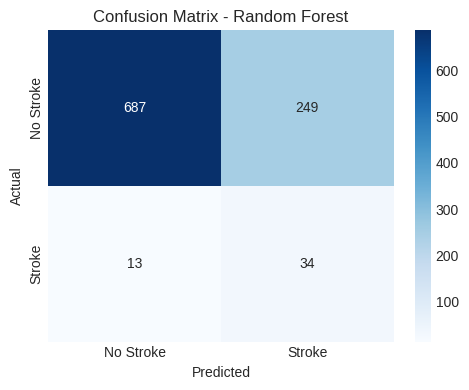

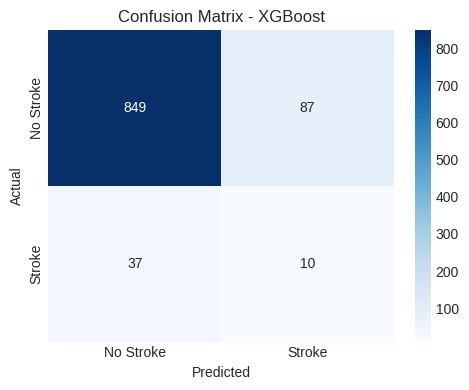

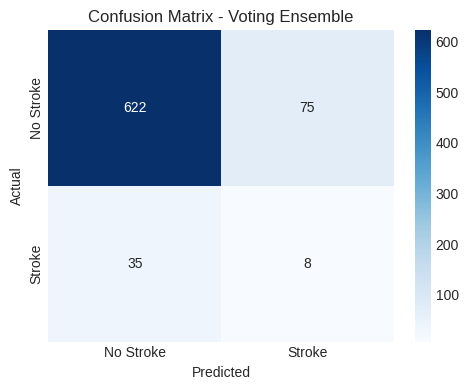

In [ ]:
rf_pd = rf_predictions.select("prediction", "stroke").toPandas()
xg_pd = xg_predictions.select("prediction", "stroke").toPandas()
ensemble_pd = ensemble_predictions.select("ensemble_prediction", "stroke") \
                                  .withColumnRenamed("ensemble_prediction", "prediction") \
                                  .toPandas()

from sklearn.metrics import confusion_matrix

def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No Stroke", "Stroke"], yticklabels=["No Stroke", "Stroke"])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {title}')
    plt.tight_layout()
    plt.show()

plot_conf_matrix(rf_pd["stroke"], rf_pd["prediction"], "Random Forest")

plot_conf_matrix(xg_pd["stroke"], xg_pd["prediction"], "XGBoost")

if 'ensemble_pd' in locals():
    plot_conf_matrix(ensemble_pd["stroke"], ensemble_pd["prediction"], "Voting Ensemble")


Number of features: 7
Calculated side length for square: 3
Square size needed: 9


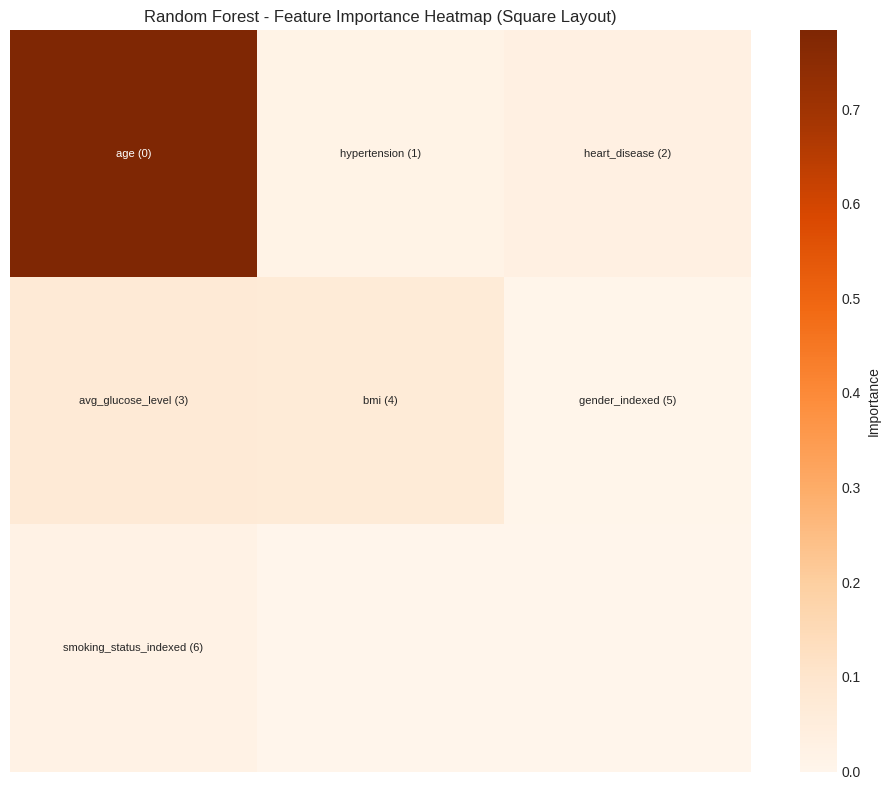

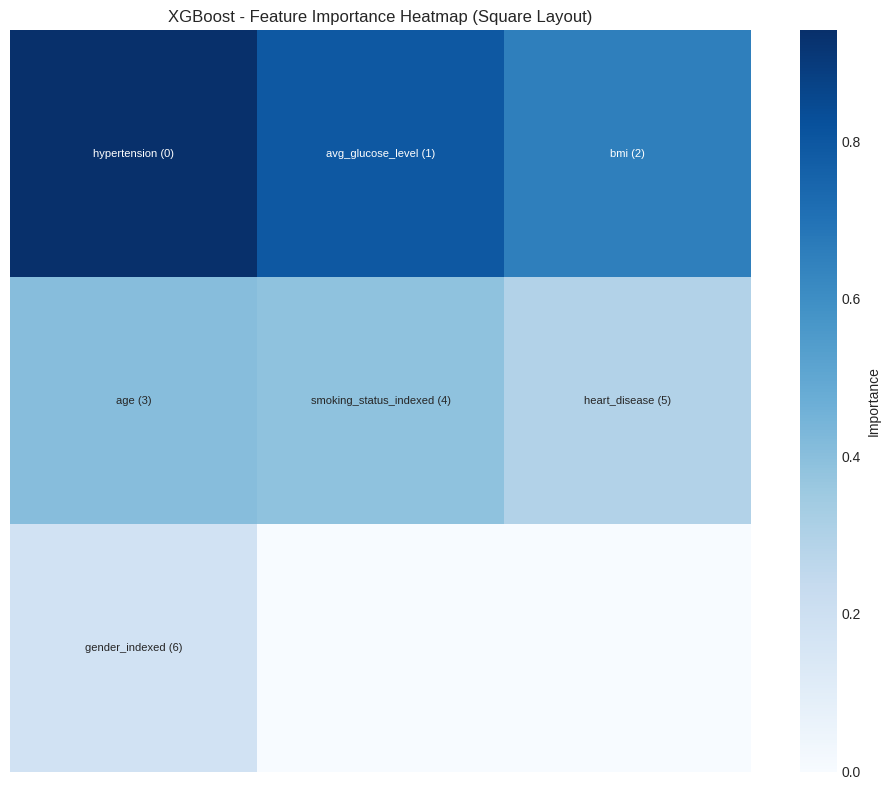

In [ ]:
from pyspark.ml.feature import VectorAssembler
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

feature_names = feature_columns_for_assembler
num_features = len(feature_names)

side = math.ceil(math.sqrt(num_features))
square_size = side * side

print(f"Number of features: {num_features}")
print(f"Calculated side length for square: {side}")
print(f"Square size needed: {square_size}")

rf_importance_padded = np.pad(rf_importances, (0, square_size - num_features))
rf_square = rf_importance_padded.reshape(side, side)

xg_importance_padded = np.pad(xg_importances_sorted, (0, square_size - len(xg_importances_sorted)))
xg_square = xg_importance_padded.reshape(side, side)

def get_square_labels(names, side):
    labels = [f"{name} ({i})" if i < len(names) else "" for i, name in enumerate(names)]
    labels_padded = labels + [""] * (side * side - len(labels))
    return np.array(labels_padded).reshape(side, side)

rf_labels = get_square_labels(feature_names, side)
xg_labels = get_square_labels(xg_sorted_names, side)


plt.figure(figsize=(10, 8))
sns.heatmap(rf_square, annot=rf_labels, fmt='s', cmap='Oranges', square=True, cbar_kws={'label': 'Importance'}, annot_kws={'size': 8})
plt.title("Random Forest - Feature Importance Heatmap (Square Layout)")
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(xg_square, annot=xg_labels, fmt='s', cmap='Blues', square=True, cbar_kws={'label': 'Importance'}, annot_kws={'size': 8})
plt.title("XGBoost - Feature Importance Heatmap (Square Layout)")
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

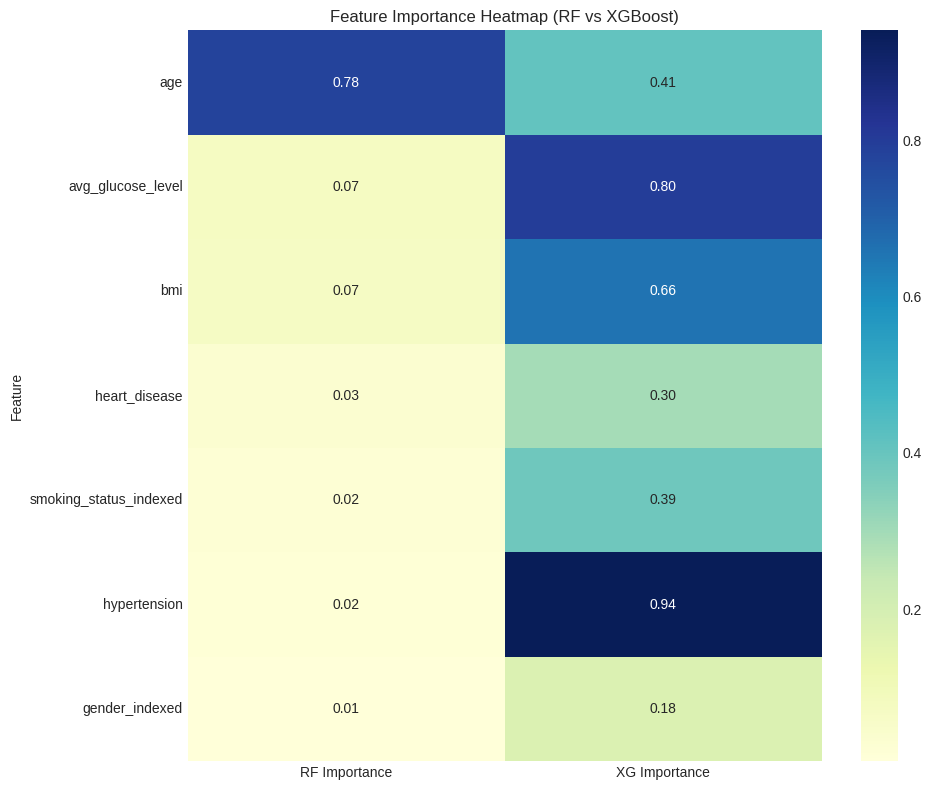

In [ ]:
import seaborn as sns

rf_df = pd.DataFrame({
    'Feature': feature_names,
    'RF Importance': rf_importances
}).sort_values(by='RF Importance', ascending=False)

xg_df = pd.DataFrame(list(xg_importances.items()), columns=['FeatureIndex', 'XG Importance'])

xg_df['Feature'] = xg_df['FeatureIndex'].apply(lambda i: feature_names[i])
xg_df = xg_df[['Feature', 'XG Importance']]

merged_df = pd.merge(rf_df, xg_df, on='Feature', how='outer').fillna(0)
merged_df.set_index('Feature', inplace=True)

merged_df = merged_df.sort_values(by='RF Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.heatmap(merged_df, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title("Feature Importance Heatmap (RF vs XGBoost)")
plt.tight_layout()
plt.show()

In [ ]:
ensemble_predictions = ensemble_df.join(test_data.select("features", "stroke"), on="features", how="inner")

ensemble_accuracy = evaluator_accuracy.evaluate(ensemble_predictions)
ensemble_f1 = evaluator_f1.evaluate(ensemble_predictions)

results_data = {
    "Model": ["Random Forest", "XGBoost", "Ensemble (40/60)"],
    "Accuracy": [rf_accuracy, xg_accuracy, ensemble_accuracy],
    "F1-Score": [rf_f1, xg_f1, ensemble_f1]
}
results_df = pd.DataFrame(results_data)

print("\n" + "="*50)
print("1 & 2: TABEL PERFORMA AKURASI DAN F1-SCORE")
print("="*50)
print(results_df.to_string(index=False, formatters={'Accuracy':'{:.4f}'.format, 'F1-Score':'{:.4f}'.format}))


1 & 2: TABEL PERFORMA AKURASI DAN F1-SCORE
           Model Accuracy F1-Score
   Random Forest   0.7345   0.8110
         XGBoost   0.8718   0.8963
Ensemble (40/60)   0.8523   0.8751


In [ ]:
best_model_name = results_df.loc[results_df['F1-Score'].idxmax()]['Model']
best_f1_score = results_df['F1-Score'].max()

print("\n" + "="*50)
print("3. KESIMPULAN MODEL TERBAIK")
print("="*50)
print(f"Model terbaik adalah **{best_model_name}** dengan F1-Score **{best_f1_score:.4f}**.")


3. KESIMPULAN MODEL TERBAIK
Model terbaik adalah **XGBoost** dengan F1-Score **0.8963**.


In [ ]:
print("\n" + "="*50)
print("4 & 5: BAGAIMANA MODEL MENENTUKAN STROKE")
print("="*50)


feature_names = assembler.getInputCols()

importances = None

if 'XGBoost' in best_model_name:
    best_model_obj = xg_model.bestModel

    raw_importances_dict = best_model_obj.get_feature_importances()
    sorted_keys = sorted(raw_importances_dict.keys(), key=lambda x: int(x[1:]))
    importances = [raw_importances_dict[key] for key in sorted_keys]

elif 'Random Forest' in best_model_name:
    best_model_obj = rf_model.bestModel

    importances = best_model_obj.featureImportances.toArray()

else:

    print("Menganalisis komponen terkuat (XGBoost) dari model Ensemble...")
    best_model_obj = xg_model.bestModel
    raw_importances_dict = best_model_obj.get_feature_importances()
    sorted_keys = sorted(raw_importances_dict.keys(), key=lambda x: int(x[1:]))
    importances = [raw_importances_dict[key] for key in sorted_keys]


if importances is None:
    print("Could not retrieve feature importances for the best model.")
else:

    feature_importance_df = pd.DataFrame(list(zip(feature_names, importances)), columns=['Indikator', 'Tingkat Penting'])

    try:
        feature_importance_df['Tingkat Penting'] = feature_importance_df['Tingkat Penting'].astype(float)
    except ValueError:
         print("Warning: 'Tingkat Penting' column still contains non-numeric values after extraction.")

    feature_importance_df['Persentase'] = (feature_importance_df['Tingkat Penting'] / feature_importance_df['Tingkat Penting'].sum()) * 100
    df_sorted = feature_importance_df.sort_values(by='Persentase', ascending=False).reset_index(drop=True)


    top_3_features = df_sorted.head(3)['Indikator'].tolist()

    print("\n--- Kesimpulan Cara Model Menentukan Seseorang Stroke ---")
    print(f"Model {best_model_name} menentukan risiko stroke seseorang terutama berdasarkan tiga faktor utama:")
    print(f"1. **{top_3_features[0].replace('_imputed', '').replace('_indexed', '').title()}**")
    print(f"2. **{top_3_features[1].replace('_imputed', '').replace('_indexed', '').title()}**")
    print(f"3. **{top_3_features[2].replace('_imputed', '').replace('_indexed', '').title()}**")

    print("\nDetail Tingkat Penting Fitur:")
    print(df_sorted.to_string(index=False, formatters={'Tingkat Penting':'{:.4f}'.format, 'Persentase':'{:.2f}%'.format}))


4 & 5: BAGAIMANA MODEL MENENTUKAN STROKE

--- Kesimpulan Cara Model Menentukan Seseorang Stroke ---
Model XGBoost menentukan risiko stroke seseorang terutama berdasarkan tiga faktor utama:
1. **Bmi**
2. **Age**
3. **Avg_Glucose_Level**

Detail Tingkat Penting Fitur:
             Indikator Tingkat Penting Persentase
                   bmi        737.0000     28.64%
                   age        731.0000     28.41%
     avg_glucose_level        681.0000     26.47%
smoking_status_indexed        197.0000      7.66%
        gender_indexed        107.0000      4.16%
          hypertension         79.0000      3.07%
         heart_disease         41.0000      1.59%



--- 5. Visualisasi Persentase Indikator Penentu Stroke ---


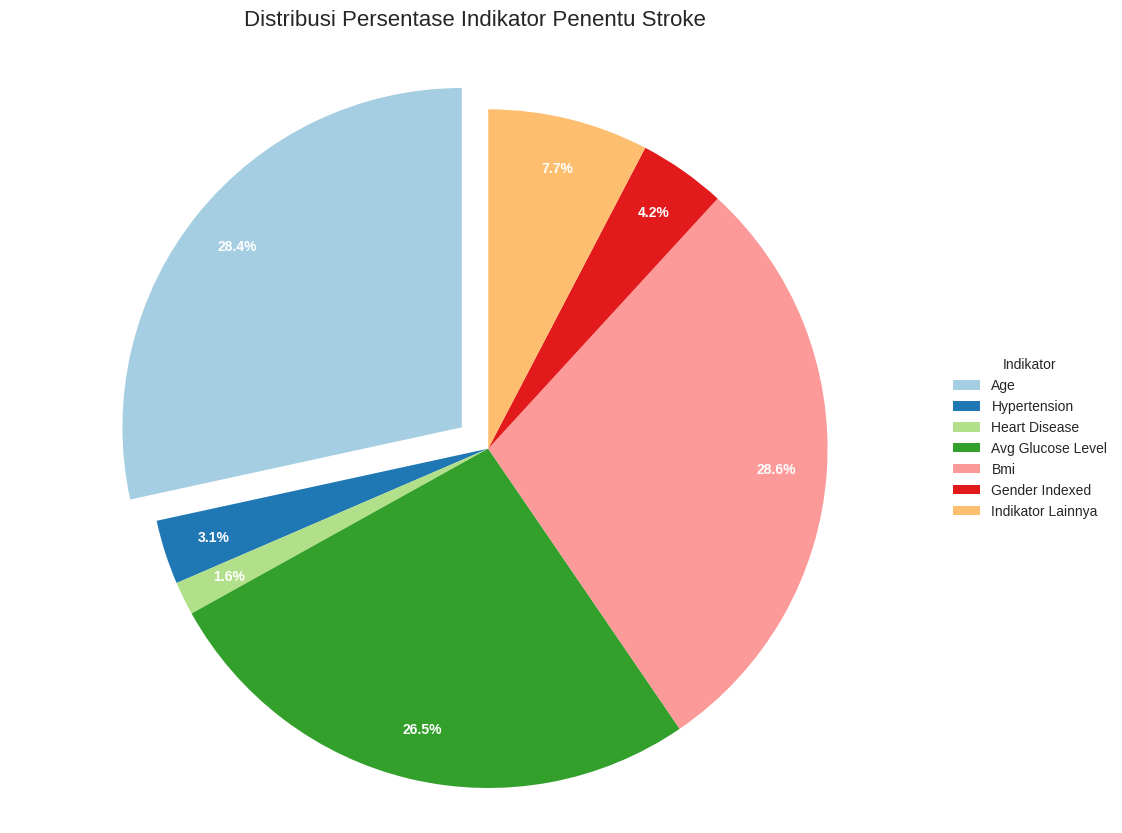

In [ ]:
print("\n--- 5. Visualisasi Persentase Indikator Penentu Stroke ---")

top_n = 6
pie_data = feature_importance_df.head(top_n).copy()
other_percentage = feature_importance_df.iloc[top_n:]['Persentase'].sum()

if other_percentage > 0:
  other_row = pd.DataFrame([{'Indikator': 'Indikator Lainnya', 'Persentase': other_percentage}])
  pie_data = pd.concat([pie_data, other_row], ignore_index=True)

pie_data['Indikator'] = pie_data['Indikator'].apply(
  lambda x: x.replace('_imputed', '').replace('_encoded', '').replace('_', ' ').title()
)

explode = [0] * len(pie_data)
explode[0] = 0.1

fig, ax = plt.subplots(figsize=(12, 10))
wedges, texts, autotexts = ax.pie(
  pie_data['Persentase'],
  autopct='%1.1f%%',
  startangle=90,
  explode=explode,
  pctdistance=0.85,
  colors=plt.cm.Paired.colors
)
plt.setp(autotexts, size=10, weight="bold", color="white")
ax.set_title("Distribusi Persentase Indikator Penentu Stroke", fontsize=16, pad=20)

ax.legend(wedges, pie_data['Indikator'],
  title="Indikator",
  loc="center left",
  bbox_to_anchor=(1, 0, 0.5, 1))

ax.axis('equal')
plt.show()

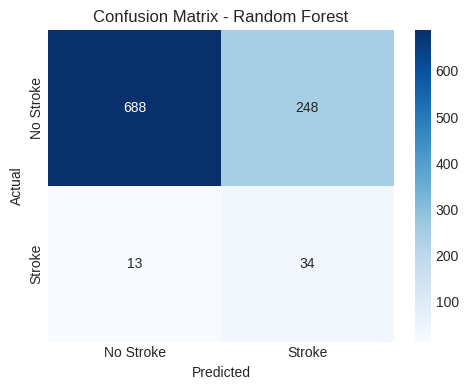

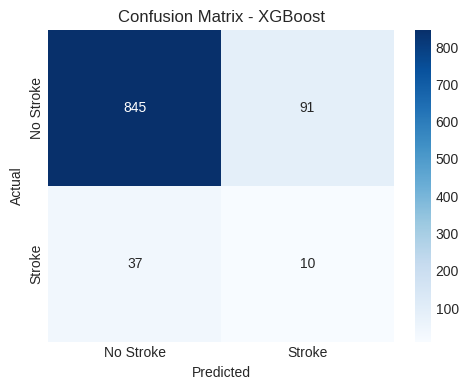

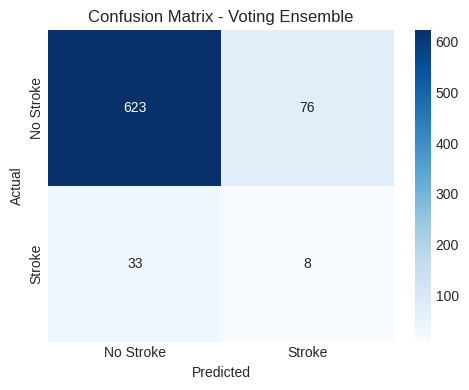

In [ ]:
# Convert to Pandas for Random Forest
rf_pd = rf_predictions.select("prediction", "stroke").toPandas()

# Convert to Pandas for XGBoost
xg_pd = xg_predictions.select("prediction", "stroke").toPandas()
# Convert to Pandas for Ensemble
ensemble_pd = ensemble_predictions.select("prediction", "stroke") \
                                  .withColumnRenamed("prediction", "prediction") \
                                  .toPandas()

from sklearn.metrics import confusion_matrix

def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No Stroke", "Stroke"], yticklabels=["No Stroke", "Stroke"])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {title}')
    plt.tight_layout()
    plt.show()

# Random Forest
plot_conf_matrix(rf_pd["stroke"], rf_pd["prediction"], "Random Forest")

# XGBoost
plot_conf_matrix(xg_pd["stroke"], xg_pd["prediction"], "XGBoost")

# Ensemble (jika tersedia)
if 'ensemble_pd' in locals():
    plot_conf_matrix(ensemble_pd["stroke"], ensemble_pd["prediction"], "Voting Ensemble")